# コンジョイント分析を用いて、消費者の好みを分析してみよう  

以下は、コンジョイント分析を行うためのpythonコードです。
- pythonのバージョンは3.8  
- 他のモジュールのバージョンについては、githubにアップロードしているファイルをダウンロードして、`myenv.txt` をご確認ください。

## モジュールのインポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## データの読み込み

In [2]:
df = pd.read_csv('./data/data.csv')
# x, y の指定
y = pd.DataFrame(df['score'])
x = df.drop(columns=['score'])
x.head(20)

,auto-lock,distToUniv,isParking,fee
0,1,1,1,2
1,1,1,2,1
2,1,2,1,1
3,1,2,2,3
4,2,2,2,2
5,2,2,1,1
6,2,1,2,1
7,2,1,1,3
8,1,1,1,2
9,1,1,2,1


このデータは２人分、合計１６個の回答を示しています。例えば一番上の`auto-lock 1, distToUniv 1, isParking 1, fee 2`では、  
オートロックあり、大学からの距離がちかい、駐車場あり、家賃８万（１～３があって、それぞれ、６，８，１０万に対応）という条件を示しています。これに対して、それぞれ被験者（今回は私が勝手に回答）が魅力度のスコアを付けます。

## ダミー変数への変換  
ここでは、`pd.get_dummies`関数を用いて、そのカードに、該当の項目が書かれているかどうかを 0/1で示します。 
one-hotベクトルに直しているのと似ています。  
`drop_first`をtrueにして、その項目のはじめの要素は削除するようにしています。例えば、駐車場の有無では、駐車場がある、という要素が0である場合と、駐車場がない、という要素が1である場合は同じ意味です。

In [3]:
x_dum = pd.get_dummies(x, columns=x.columns, drop_first=True)
x_dum.head()

,auto-lock_2,distToUniv_2,isParking_2,fee_2,fee_3
0,0,0,0,1,0
1,0,0,1,0,0
2,0,1,0,0,0
3,0,1,1,0,1
4,1,1,1,1,0


In [4]:
# drop_firstを無効にした場合を確認。_1のものが残っていることがわかる。ここではこのデータは使わない
x_dum_noDrop = pd.get_dummies(x, columns=x.columns, drop_first=False)
x_dum_noDrop.head()

,auto-lock_1,auto-lock_2,distToUniv_1,distToUniv_2,isParking_1,isParking_2,fee_1,fee_2,fee_3
0,1,0,1,0,1,0,0,1,0
1,1,0,1,0,0,1,1,0,0
2,1,0,0,1,1,0,1,0,0
3,1,0,0,1,0,1,0,0,1
4,0,1,0,1,0,1,0,1,0


In [5]:
df.describe() #要素の平均や標準偏差などの基本的な統計データを表示させる

,score,auto-lock,distToUniv,isParking,fee
count,16.000000,16.000000,16.000000,16.000000,16.000000
mean,7.187500,1.500000,1.500000,1.500000,1.750000
std,2.644964,0.516398,0.516398,0.516398,0.856349
min,2.000000,1.000000,1.000000,1.000000,1.000000
25%,6.000000,1.000000,1.000000,1.000000,1.000000
50%,7.000000,1.500000,1.500000,1.500000,1.500000
75%,8.625000,2.000000,2.000000,2.000000,2.250000
max,12.000000,2.000000,2.000000,2.000000,3.000000


## 切片を追加 
また、コンジョイントカードに記載されている内容に加えて、その他の影響がある場合に備えて、定数項も加えます。

この操作によってフィッティングするときの切片を計算することができます。  
https://www.statsmodels.org/stable/generated/statsmodels.tools.tools.add_constant.html

In [6]:
x_dum=sm.add_constant(x_dum) # constという要素を追加
x_dum.head(10) # constが追加されたことを確認

C:\Users\itaku\anaconda3\envs\py38_geopanda\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,auto-lock_2,distToUniv_2,isParking_2,fee_2,fee_3
0,1.0,0,0,0,1,0
1,1.0,0,0,1,0,0
2,1.0,0,1,0,0,0
3,1.0,0,1,1,0,1
4,1.0,1,1,1,1,0
5,1.0,1,1,0,0,0
6,1.0,1,0,1,0,0
7,1.0,1,0,0,0,1
8,1.0,0,0,0,1,0
9,1.0,0,0,1,0,0


## OLS (Ordinary Least Squares) でフィッティング

In [7]:
model = sm.OLS(y, x_dum)
# フィッティングを実行
result = model.fit()
# 結果の一覧を表示
result.summary()

C:\Users\itaku\anaconda3\envs\py38_geopanda\lib\site-packages\scipy\stats\stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     46.32
Date:                Mon, 03 Jan 2022   Prob (F-statistic):           1.35e-06
Time:                        13:46:07   Log-Likelihood:                -12.272
No. Observations:                  16   AIC:                             36.54
Df Residuals:                      10   BIC:                             41.18
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            9.7500      0.368     26.463      0.000       8.929      10.571
auto-lock_2      0.7500      0.330      2.276      0.046       0.016       1.484
distToUniv_2    -3.0000      0.330     -9.104      0.000      -3.734      -2.266
isParking_2      0.3750      0.330      1.138      0.282      -0.359       1.109
fee_2           -1.6875      0.404     -4.181      0.002      -2.587      -0.788
fee_3           -4.8125      0.404    -11.924      0.000      -5.712      -3.913
==============================================================================
Omnibus:                        0.797   Durbin-Watson:                   2.795
Prob(Omnibus):                  0.671   Jarque-Bera (JB):                0.028
Skew:                          -0.010   Prob(JB):                        0.986
Kurtosis:                       3.205   Cond. No.                         4.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 結果の一部を取り出し  
`結果を見てみる`セクションで議論するため、weightとｐ値を取り出します

In [8]:
df_result_selected = pd.DataFrame({
    'weight': result.params.values
    , 'p_val': result.pvalues
})
df_result_selected.head(10)

,weight,p_val
const,9.7500,1.369002e-10
auto-lock_2,0.7500,4.610362e-02
distToUniv_2,-3.0000,3.732512e-06
isParking_2,0.3750,2.816648e-01
fee_2,-1.6875,1.884264e-03
fee_3,-4.8125,3.101164e-07


## 可視化のための準備  
コンジョイント分析の結果を可視化するための準備を行います。上のdrop_Firstを有効にして、_ 1 がつく変数は落とされていました。グラフで表示させるため復帰させます。これらの重みは0とします。

In [9]:
for s in df_result_selected.index:
    partitioned_string = s.partition('_')
    if partitioned_string[2] == "2":
        valBase = partitioned_string[0] + "_1"
        df_valBase = pd.DataFrame(data =np.zeros((1,2)),
                                  index = [valBase],
                                  columns = ["weight","p_val"])
        df_result_selected = pd.concat([df_result_selected,df_valBase])

df_result_selected.head(20) 

,weight,p_val
const,9.7500,1.369002e-10
auto-lock_2,0.7500,4.610362e-02
distToUniv_2,-3.0000,3.732512e-06
isParking_2,0.3750,2.816648e-01
fee_2,-1.6875,1.884264e-03
fee_3,-4.8125,3.101164e-07
auto-lock_1,0.0000,0.000000e+00
distToUniv_1,0.0000,0.000000e+00
isParking_1,0.0000,0.000000e+00
fee_1,0.0000,0.000000e+00


## ｐ値に応じてバーの色を変える：  
p値が0.01以上、0.05以下の場合はシアン、0.01以下の場合は青、0.05以上（あまり信用できない）の場合は赤に設定します。

In [10]:
bar_col = []
for p_val in df_result_selected['p_val']:
    # print(p_val)
    if 0.01 < p_val < 0.05:
        bar_col.append('Cyan')
    elif p_val < 0.01:
        bar_col.append('blue')
    else:
        bar_col.append('red')

# p値が0.05以下のものを青、そうでないものを青とする
df_bar_col = pd.DataFrame(data = bar_col, 
                          columns=['bar_col'], 
                          index = df_result_selected.index)

df_result_selected = pd.concat([df_result_selected,df_bar_col], axis=1)
df_result_selected.head(20)

,weight,p_val,bar_col
const,9.7500,1.369002e-10,blue
auto-lock_2,0.7500,4.610362e-02,Cyan
distToUniv_2,-3.0000,3.732512e-06,blue
isParking_2,0.3750,2.816648e-01,red
fee_2,-1.6875,1.884264e-03,blue
fee_3,-4.8125,3.101164e-07,blue
auto-lock_1,0.0000,0.000000e+00,blue
distToUniv_1,0.0000,0.000000e+00,blue
isParking_1,0.0000,0.000000e+00,blue
fee_1,0.0000,0.000000e+00,blue


## グラフを表示させる  
_ 1 とつくものが基準になっているので、それをもとに同一カテゴリが正または負の影響があるか見てください。

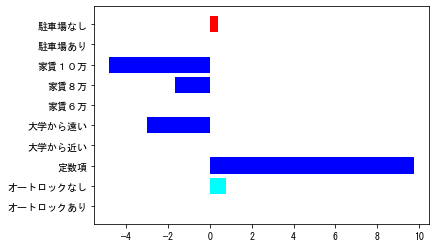

In [11]:
# プロットするときに日本語でも文字化けしないように設定
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
# アルファベット順位
df_result_selected = df_result_selected.sort_index()
xbar = np.arange(len(df_result_selected['weight']))
plt.barh(xbar, df_result_selected['weight'], color=df_result_selected['bar_col'])
index_JP = ["駐車場なし","駐車場あり","家賃１０万","家賃８万","家賃６万","大学から遠い","大学から近い","定数項","オートロックなし","オートロックあり"]
plt.yticks(xbar, labels=index_JP[::-1]) # 順番があうように順番を逆にする
plt.show()

# 結果を見てみる  

## 上のOLS Regression Resultsについて（result.summary()で表示したところ）
- R-squaredは約0.96と高い値を示している
=> 良いフィッティング結果を得ることができた。簡単なデータではあったが、スコアを決定する要因の全体の9割以上を説明することができている。私の重視する家賃、大学までの近さがともに入っているためだと考えられる。ただ、これが私の家選びの傾向を完全に理解した、ということにはならないと思います（「考えたこと」章を参照ください）
- P>|t|	は、isParking_2以外、統計的に有意である（有意水準を5%とした場合）ことがわかります。
=> isParkingは個人的にどちらでも良いので、私がこの練習用データを作るときは、ほとんど見ずに回答していました。そのため、この限られたデータではうまくフィッティングできなかったのではないかと考えられます。もしより多くの似た考えをもつ回答者がいれば、このｐ値もより小さく（有意になり）、かつ重みが小さな値に収束していくはずです。P>|t|の欄の値が大きいものばかりだと、たまたま重みが大きくなっただけの偶然であることが否定できず、コンジョイント分析から多くの示唆を得ることができないため、今回はよい練習データになっていてよかったです。
- 多重共線性について：Cond. No.(Condition number)を確認します。statsmodelsのドキュメンテーションによると、  

> One way to assess multicollinearity is to compute the condition number. Values over 20 are worrisome (see Greene 4.9).  

とあります。今回は20以下なので、多重共線性についてもひとまず大丈夫そうです。

https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html

- 最後の色に分けられたグラフでは、**私が家賃安め＆大学から近め を優先してよいスコアを付けたので、納得のいくグラフ**です。駐車場がない場合が少しポジティブな方向に出ていますが、特に私は考えず記入していました。ここでは、ｐ値が0.05より高く赤で示されていて、特に考えず記入しなかったことともつじつまがあっています。

# 考えたこと  
この分析を勉強してみて考えたことを以下に記載します。この分析は勉強中なので的外れなところもあるかもしれませんのでご注意ください。
## コンジョイント分析全体について  
- 今回はpythonによる実装を中心に議論しましたが、解析の中身自体は重回帰をして、その重みをもって議論しているため、比較的シンプルな方法なのではないかと思いました。  
- 機械学習でいう、LIMEとアイデア似ているところが多いな思いました。LIMEでは、例えば画像の場合、ランダムにブラックアウトさせて、そのときのスコアの変動を見ます。そこでも線形回帰が使われていて、その重みを用いて機械学習や深層学習による判断根拠の可視化を行います。  

## 疑問点や改良点について  
- 今回は、被験者の少ないデータを自作し、テストしています。しかし、被験者が多くなった場合は、スコアのベースラインも被験者によって異なるのでその補正が必要だと思います。例えば、被験者によって、高めに点を付ける人、そうでない人が存在すると、各被験者のスコアの平均で割り算したり、何らかの標準化が必要です。  
- 重回帰による重要度の議論について：上で述べたLIMEでは、線形回帰をするために重回帰を用いたり、決定木を用いています。コンジョイント分析でも、うまく重回帰ではフィッティングできず、決定係数の低い場合は決定木を用いてみても良いのかもしれませんね。
- 今回の練習データでは決定係数も高く、P>|t|の値も良好でした。ただ、この結果から私の家選びの基準を完全に推論できるかというとそうでもなくて、例えば、家がキレイか、ユニットバス/セパレートか、なども個人的に重視するポイントです。確かに家賃も気にはするものの、そういったコンジョイントカードにはない要素が自身の家選びにおける重要項目であることも多いです。そのため、スコア自体がどの要素から来ているかいう予測というよりかは、今回勉強したコンジョイント分析では、カードにある各要素どうしを比較する、という目的で使うことを意識する必要がありそうですね（？）
- コンジョイント分析では、コンジョイントカードの内容がカテゴリーデータなので、数値（例：家賃）が混じるとバリデーションが少なくなったりしてしまいますね。また、今回は等間隔に刻んだので問題なさそうですが、解析上は家賃の差分２万円ということは考慮せず、単にことなるカテゴリーデータとして扱うので、少し違和感がありました。また継続して勉強してみたいと思います。

# 参考記事  
グロービス経営大学院:コンジョイント分析  
https://mba.globis.ac.jp/about_mba/glossary/detail-11804.html  
Pythonでコンジョイント分析に挑戦  
https://wannko5296.hatenablog.com/entry/conjoint_analysis_in_python  